# Traffic data analysis

The objective of this notebook is to use data provided by Victor Couture and team to crown "Canada's Worst Commute".

In [1]:
import pandas as pd

In [ ]:
MIN_TRIP_DISTANCE = 10

MORNING_RUSH_HOUR_START = 8
MORNING_RUSH_HOUR_END = 10

EVENING_RUSH_HOUR_START = 17
EVENING_RUSH_HOUR_END = 19

MIN_DATA_POINTS_NONRUSHHOUR = 10
MIN_DATA_POINTS_RUSHHOUR = 5

START_DATE = pd.Timestamp(f"2024-10-01")
END_DATE = pd.Timestamp(f"2025-09-30")

Filtering for only the columsn I need so the file doesn't get too large.

In [4]:
df = pd.read_parquet('data/victor/alltrips_canada_2024_2025.parquet')

# Create a datetime column for analysis
df.head(1)

,tripid,mode,citycode,cityname_corrected,time_full_str,traffic_min,notraffic_min,dayofweek,tz,trip_dist,lat_dest,lon_dest,lat_orig,lon_orig
0,101497520,0.0,20370,Calgary,20240111 00:56:12,13.3,13.1,3,America/Edmonton,9.548,51.060974,-113.951439,51.04414,-114.059586


In [ ]:
df["cityname_corrected"] = df["cityname_corrected"].str.replace("é", "e")

In [5]:
# Create a datetime column for analysis
df['time_dt'] = pd.to_datetime(df['time_full_str'])

In [ ]:
df = df[(df['time_dt'] <= END_DATE) & (df['time_dt'] >= START_DATE)]

df.head()

,tripid,mode,citycode,cityname_corrected,time_full_str,traffic_min,notraffic_min,dayofweek,tz,trip_dist,lat_dest,lon_dest,lat_orig,lon_orig,time_dt
3970387,101497520,0.0,20370,Calgary,20241101 09:05:27,15.650000,15.283333,4,America/Edmonton,9.603,51.060974,-113.951439,51.044140,-114.059586,2024-11-01 09:05:27
3970388,101497521,0.0,20370,Calgary,20241031 00:02:12,13.583333,15.983333,3,America/Edmonton,9.947,51.044140,-114.059586,51.060974,-113.951439,2024-10-31 00:02:12
3970389,101497521,0.0,20370,Calgary,20241031 08:15:44,21.383333,15.983333,3,America/Edmonton,9.947,51.044140,-114.059586,51.060974,-113.951439,2024-10-31 08:15:44
3970390,101497540,0.0,20370,Calgary,20241101 14:01:34,23.166667,19.516667,4,America/Edmonton,15.527,50.949066,-114.085335,51.044357,-114.061646,2024-11-01 14:01:34
3970391,101497551,0.0,20370,Calgary,20241030 20:16:30,13.583333,12.516667,2,America/Edmonton,10.061,51.044140,-114.063362,51.000732,-114.118637,2024-10-30 20:16:30


Check data start time and end time.

In [7]:
display(df["time_full_str"].min(), df["time_full_str"].max())

'20241029 05:39:11'

'20250929 23:59:46'

How many cities is there data for?

In [8]:
df["cityname_corrected"].unique()

array(['Calgary', 'Edmonton', 'Halifax', 'Hamilton',
       'Kitchener-Cambrigde-Waterloo', 'London', 'Montréal', 'Oshawa',
       'Ottawa', 'Québec', 'Saskatoon', 'St. Catharines-Niagara',
       'Toronto', 'Vancouver', 'Victoria', 'Windsor', 'Winnipeg'],
      dtype=object)

Let's now see how many cities we have in this dataset.

In [9]:
df.loc[:, ["cityname_corrected", "tz"]].drop_duplicates()

,cityname_corrected,tz
3970387,Calgary,America/Edmonton
3971133,Edmonton,America/Edmonton
3971843,Halifax,America/Halifax
3972826,Hamilton,America/Toronto
3973695,Kitchener-Cambrigde-Waterloo,America/Toronto
3974686,London,America/Toronto
3975805,Montréal,America/Toronto
3977878,Oshawa,America/Toronto
3978757,Ottawa,America/Toronto
3980304,Québec,America/Toronto


For this table, I’ve excluded routes that are less than 10km long, and only included routes with at least 3 data points collected over the past 6 months in both non-rush hour and rush hour (8-10am, 5-7pm) times. I've excluded everything under 10km, because that doesn't really feel like it qualifies as a commute.

In [10]:
# --- Rush Hour Analysis most recent year
weekdays_df = df[(df['time_dt'].dt.weekday < 5) & (df['trip_dist'] >= MIN_TRIP_DISTANCE) & (df['mode'] == 0)].copy()

hour = weekdays_df['time_dt'].dt.hour

is_rush_hour = ((hour >= MORNING_RUSH_HOUR_START) & (hour < MORNING_RUSH_HOUR_END)) | ((hour >= EVENING_RUSH_HOUR_START) & (hour < EVENING_RUSH_HOUR_END))

weekdays_df['period'] = 'Non-Rush Hour'
weekdays_df.loc[is_rush_hour, 'period'] = 'Rush Hour'

In [ ]:
# --- Rush Hour Analysis most recent year

# Ensure origin/dest exist (from earlier cells)
if 'origin' not in weekdays_df.columns and 'lat_orig' in weekdays_df.columns:
    weekdays_df['origin'] = weekdays_df['lat_orig'].astype(str) + ',' + weekdays_df['lon_orig'].astype(str)
if 'dest' not in weekdays_df.columns and 'lat_dest' in weekdays_df.columns:
    weekdays_df['dest'] = weekdays_df['lat_dest'].astype(str) + ',' + weekdays_df['lon_dest'].astype(str)

# Group traffic_min by trip/period to get mean and count per period
grouping_cols = ['tripid', 'cityname_corrected', 'trip_dist', 'period']
agg_times = weekdays_df.groupby(grouping_cols)['traffic_min'].agg(['mean', 'count']).reset_index()

# Pivot traffic stats so we have mean/count per period side-by-side
comparison_table = agg_times.pivot_table(
    index=[col for col in grouping_cols if col != 'period'],
    columns='period',
    values=['mean', 'count']
).reset_index()

# Flatten multiindex column names
comparison_table.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in comparison_table.columns.values]

# Rename traffic columns to friendly names
comparison_table.rename(columns={
    'mean_Non-Rush Hour': 'mean_non_rush_hour',
    'mean_Rush Hour': 'mean_rush_hour',
    'count_Non-Rush Hour': 'count_non_rush_hour',
    'count_Rush Hour': 'count_rush_hour',
    'tripid_': 'tripid',
    'mode_': 'mode',
    'cityname_corrected_': 'cityname_corrected',
    'trip_dist_': 'trip_dist',
}, inplace=True)

# Compute a single overall mean for notraffic_min (include all periods)
notraffic_overall = weekdays_df.groupby(['tripid', 'cityname_corrected', 'trip_dist'])['notraffic_min'].mean().reset_index().rename(columns={'notraffic_min': 'mean_notraffic'})

# Compute 90th percentile travel time during Rush Hour per trip (p90)
rush_df = weekdays_df[weekdays_df['period'] == 'Rush Hour']
p90_rush = rush_df.groupby(['tripid', 'cityname_corrected', 'trip_dist'])['traffic_min'].quantile(0.9).reset_index().rename(columns={'traffic_min': 'p90_rush_hour'})

# Merge the overall notraffic mean and p90 into the comparison table
comparison_table = comparison_table.merge(notraffic_overall, on=['tripid', 'cityname_corrected', 'trip_dist'], how='left')
comparison_table = comparison_table.merge(p90_rush, on=['tripid', 'cityname_corrected', 'trip_dist'], how='left')

# Bring origin/dest into the comparison table using a representative value (first)
orig_dest = weekdays_df.groupby(['tripid', 'cityname_corrected', 'trip_dist']).agg({'origin': 'first', 'dest': 'first'}).reset_index()
comparison_table = comparison_table.merge(orig_dest, on=['tripid', 'cityname_corrected', 'trip_dist'], how='left')

comparison_table.fillna(0, inplace=True)
# New metric: difference between rush hour mean and overall notraffic (free-flow)
comparison_table['rush_vs_freeflow_diff'] = comparison_table['mean_rush_hour'] - comparison_table['mean_notraffic']
# Percent impact relative to free-flow (notraffic)
# Avoid division by zero
comparison_table['rush_vs_freeflow_pct'] = comparison_table.apply(lambda r: (r['rush_vs_freeflow_diff'] / r['mean_notraffic'] * 100) if r['mean_notraffic'] else 0, axis=1)
comparison_table['p90_vs_freeflow'] = comparison_table['p90_rush_hour'] - comparison_table['mean_notraffic']

# Convert count columns to integers where present
for col in ['count_non_rush_hour', 'count_rush_hour']:
    if col in comparison_table.columns:
        comparison_table[col] = comparison_table[col].astype(int)

# Round numeric columns: trip_dist to 1 decimal, others to 2 decimals
if 'trip_dist' in comparison_table.columns:
    comparison_table['trip_dist'] = comparison_table['trip_dist'].round(1)
num_cols = ['mean_non_rush_hour', 'mean_rush_hour', 'mean_notraffic', 'rush_vs_freeflow_diff', 'rush_vs_freeflow_pct', 'p90_rush_hour']
for c in num_cols:
    if c in comparison_table.columns:
        comparison_table[c] = comparison_table[c].round(2)

# Final sorting and filtering
final_table = comparison_table.sort_values('rush_vs_freeflow_diff', ascending=False)
final_table = final_table[(final_table['count_non_rush_hour'] >= MIN_DATA_POINTS_NONRUSHHOUR) & (final_table['count_rush_hour'] >= MIN_DATA_POINTS_RUSHHOUR)]

# Include origin/dest and p90 in display
final_table["rank"] = range(1,len(final_table)+1)
display_cols = ['tripid', 'cityname_corrected', 'origin', 'dest', 'trip_dist', 'mean_notraffic', 'mean_rush_hour', 'rush_vs_freeflow_diff', 'rush_vs_freeflow_pct', 'p90_rush_hour']
final_table = final_table.set_index('rank')
final_table[display_cols].to_csv("results.csv")
final_table[display_cols].head(10)

,tripid,cityname_corrected,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct,p90_rush_hour
rank,,,,,,,,,,
1,101617601,Toronto,"43.867138,-79.50793","43.65489,-79.385704",43.0,35.78,62.09,26.31,73.53,69.35
2,101610311,Toronto,"43.821083,-79.34588","43.652157,-79.380554",22.8,18.95,40.18,21.22,111.97,51.27
3,303928020,Montréal,"45.50147,-73.46785","45.694843,-73.66869",38.5,31.76,51.82,20.06,63.17,67.24
4,304101661,Toronto,"43.401985,-79.76679","43.648182,-79.45746",41.1,26.67,45.53,18.86,70.71,54.93
5,101636931,Vancouver,"49.299095,-122.79921","49.240627,-123.11095",33.2,35.46,52.34,16.88,47.59,55.80
6,304156470,Vancouver,"49.11764,-122.86204","49.22628,-122.941",19.8,21.22,36.23,15.01,70.71,39.31
7,14182640,Vancouver,"49.25273,-123.11198","49.236145,-122.90907",18.7,21.92,36.14,14.22,64.86,51.09
8,431073181,Montréal,"45.53017,-73.60811","45.704674,-73.618225",29.5,27.10,40.76,13.67,50.43,54.03
9,303925231,Montréal,"45.483418,-73.721565","45.472343,-73.61273",10.6,9.62,23.25,13.63,141.72,26.88


## Individual city data

In [12]:
for city in final_table["cityname_corrected"].unique():
    city_table = final_table.loc[final_table["cityname_corrected"] == city, ["tripid", "origin", "dest", "trip_dist", "mean_notraffic", "mean_rush_hour", "rush_vs_freeflow_diff", "rush_vs_freeflow_pct"]]
    print(f"Top 5 results for {city}.")
    display(city_table.head(3))

Top 5 results for Toronto.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
1,101617601,"43.867138,-79.50793","43.65489,-79.385704",43.0,35.78,62.09,26.31,73.53
2,101610311,"43.821083,-79.34588","43.652157,-79.380554",22.8,18.95,40.18,21.22,111.97
4,304101661,"43.401985,-79.76679","43.648182,-79.45746",41.1,26.67,45.53,18.86,70.71


Top 5 results for Montréal.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
3,303928020,"45.50147,-73.46785","45.694843,-73.66869",38.5,31.76,51.82,20.06,63.17
8,431073181,"45.53017,-73.60811","45.704674,-73.618225",29.5,27.10,40.76,13.67,50.43
9,303925231,"45.483418,-73.721565","45.472343,-73.61273",10.6,9.62,23.25,13.63,141.72


Top 5 results for Vancouver.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
5,101636931,"49.299095,-122.79921","49.240627,-123.11095",33.2,35.46,52.34,16.88,47.59
6,304156470,"49.11764,-122.86204","49.22628,-122.941",19.8,21.22,36.23,15.01,70.71
7,14182640,"49.25273,-123.11198","49.236145,-122.90907",18.7,21.92,36.14,14.22,64.86


Top 5 results for Calgary.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
19,303804980,"50.992954,-113.98474","51.08427,-114.17597",23.7,22.37,32.42,10.05,44.93
32,303800211,"51.01672,-114.04036","51.145912,-114.068855",19.6,18.75,26.52,7.77,41.42
40,101501211,"51.15862,-114.04276","51.03464,-114.05718",21.4,20.75,27.98,7.23,34.84


Top 5 results for Edmonton.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
22,14164971,"53.654144,-113.6373","53.543922,-113.50546",17.0,25.10,34.19,9.09,36.20
25,101511381,"53.629314,-113.58374","53.542698,-113.503746",15.3,23.03,31.72,8.69,37.73
44,14166961,"53.655773,-113.630775","53.54413,-113.505806",16.6,24.42,31.54,7.12,29.17


Top 5 results for Ottawa.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
30,303997691,"45.416218,-75.61533","45.358833,-75.767426",17.7,12.15,20.06,7.91,65.09
31,13250680,"45.425858,-75.68709","45.36173,-75.77498",12.9,12.06,19.95,7.89,65.42
82,303982320,"45.472584,-75.773605","45.494972,-75.71696",12.6,9.22,15.32,6.11,66.27


Top 5 results for Québec.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
47,304013440,"46.850266,-71.329636","46.815975,-71.12364",39.6,29.02,36.10,7.08,24.40
75,101587151,"46.76261,-71.34955","46.814095,-71.22149",13.2,15.46,21.73,6.27,40.55
91,304013580,"46.771313,-71.32311","46.81574,-71.17342",27.0,20.19,25.90,5.71,28.26


Top 5 results for Hamilton.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
59,303859320,"43.250633,-79.83237","43.263386,-79.98583",15.7,24.27,30.94,6.67,27.47
74,101526811,"43.252384,-79.9721","43.250134,-79.84644",11.1,20.06,26.37,6.31,31.48
76,13240951,"43.258137,-79.9721","43.251637,-79.84919",11.5,18.84,25.08,6.24,33.11


Top 5 results for Winnipeg.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
85,13262771,"49.80536,-97.11661","49.8959,-97.128624",11.2,16.86,22.84,5.98,35.45
96,101654290,"49.89568,-97.126564","49.88307,-97.27934",12.7,18.67,24.18,5.51,29.52
98,101656730,"49.89988,-97.14201","49.82242,-97.082275",10.9,16.82,22.25,5.44,32.32


Top 5 results for London.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
117,303913640,"43.042477,-81.24548","42.958363,-81.24617",13.0,17.65,22.69,5.04,28.57
131,101542281,"43.05176,-81.24445","42.97595,-81.23347",10.2,14.47,19.33,4.86,33.55
220,101542650,"42.9762,-81.24205","43.04624,-81.24205",10.8,15.57,19.58,4.01,25.75


Top 5 results for Windsor.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
180,53850391,"42.313602,-83.12544","42.2907,-83.06544",10.3,13.24,17.58,4.34,32.73
280,14184141,"42.3166,-82.84056","42.278507,-83.013596",16.8,15.53,19.23,3.70,23.83
314,14184241,"42.30289,-82.826485","42.28359,-83.008446",16.8,15.63,19.16,3.53,22.60


Top 5 results for Saskatoon.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
193,304039411,"52.179768,-106.645874","52.134274,-106.74681",10.6,12.39,16.58,4.19,33.86
338,12332140,"52.11256,-106.6215","52.149864,-106.66407",10.6,11.43,14.80,3.37,29.48
376,5274700,"52.101173,-106.59575","52.174587,-106.700485",21.1,23.74,26.93,3.19,13.46


Top 5 results for Oshawa.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
219,13247620,"43.89337,-78.84806","43.907223,-78.972",18.7,14.23,18.25,4.01,28.19
249,13248101,"43.9097,-78.97303","43.897823,-78.850464",19.9,15.88,19.71,3.83,24.14
255,13247621,"43.907223,-78.972","43.89337,-78.84806",19.6,15.53,19.36,3.82,24.61


Top 5 results for Kitchener-Cambrigde-Waterloo.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
313,13242571,"43.514378,-80.50356","43.42468,-80.51249",18.5,14.94,18.46,3.53,23.62
319,303882720,"43.481506,-80.54236","43.426426,-80.4912",11.0,13.87,17.35,3.48,25.06
351,13242601,"43.510643,-80.4991","43.422935,-80.520386",17.8,14.14,17.46,3.32,23.48


Top 5 results for St. Catharines-Niagara.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
318,304061570,"43.196846,-79.21198","43.131237,-79.24769",10.1,14.30,17.78,3.48,24.31
423,304061541,"43.177822,-79.24254","43.113194,-79.20374",10.6,11.81,14.79,2.98,25.25
427,101599561,"43.10041,-79.20065","43.166557,-79.24872",15.0,13.93,16.89,2.96,21.26


Top 5 results for Halifax.


,tripid,origin,dest,trip_dist,mean_notraffic,mean_rush_hour,rush_vs_freeflow_diff,rush_vs_freeflow_pct
rank,,,,,,,,
328,101522241,"44.6554,-63.486427","44.653446,-63.59114",17.3,19.46,22.90,3.43,17.64
584,303855790,"44.65711,-63.640923","44.66712,-63.557495",12.8,15.32,17.65,2.33,15.19
601,101517511,"44.691776,-63.59114","44.641476,-63.585648",10.9,15.53,17.81,2.28,14.67


KeyboardInterrupt: 

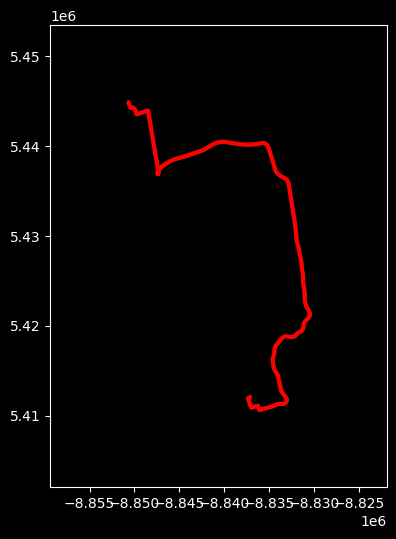

In [13]:
# Save top-3 route maps per city and fetch fresh geometry from Google Directions for each origin/destination
import os
import pathlib
import re
import time
import requests
import polyline
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString

out_dir = pathlib.Path('plots_by_route')
out_dir.mkdir(parents=True, exist_ok=True)

# Read API key (file fallback then env)
API_KEY = None
key_path = os.path.join(os.getcwd(), 'google_maps_api_key.txt')
if os.path.exists(key_path):
    with open(key_path, 'r', encoding='utf-8') as fh:
        API_KEY = fh.read().strip()
if not API_KEY:
    API_KEY = os.getenv('GOOGLE_API_KEY')
if not API_KEY:
    raise RuntimeError('Google Maps API key not found. Add google_maps_api_key.txt or set GOOGLE_API_KEY')

def safe(s):
    if s is None:
        return 'unknown'
    s = str(s)
    s = re.sub(r'[^A-Za-z0-9_\-]', '_', s)
    return s[:180]

if 'final_table' not in globals():
    raise RuntimeError('`final_table` not found. Run the Rush Hour Analysis cell first.')

ft = final_table.reset_index()
if 'rank' not in ft.columns:
    ft.insert(0, 'rank', range(1, len(ft) + 1))

# cache to avoid duplicate API calls for identical origin/dest within this run
route_cache = {}

def fetch_route_geometry(origin_str, dest_str, max_retries=3):
    key = f'{origin_str}|{dest_str}'
    if key in route_cache:
        return route_cache[key]
    url = 'https://maps.googleapis.com/maps/api/directions/json'
    params = {
        'origin': origin_str,
        'destination': dest_str,
        'alternatives': 'false',
        'mode': 'driving',
        'key': API_KEY
    }
    backoff = 1.0
    for attempt in range(1, max_retries + 1):
        try:
            resp = requests.get(url, params=params, timeout=15)
            resp.raise_for_status()
            j = resp.json()
        except Exception as e:
            if attempt == max_retries:
                raise
            time.sleep(backoff)
            backoff *= 2
            continue
        status = j.get('status')
        if status != 'OK' or not j.get('routes'):
            # For non-retryable API errors, return None
            return None
        ov = j['routes'][0].get('overview_polyline', {}).get('points')
        if not ov:
            return None
        coords_latlon = polyline.decode(ov)  # list of (lat, lon)
        coords = [(lon, lat) for lat, lon in coords_latlon]
        ls = LineString(coords)
        # create polygon buffer of 100 m by projecting to web mercator
        single_line_gdf = gpd.GeoDataFrame([{'tripid': None, 'origin': origin_str, 'dest': dest_str, 'linestring': ls}], geometry='linestring', crs='EPSG:4326')
        web = single_line_gdf.to_crs(epsg=3857)
        web['polygon_100m'] = web.geometry.buffer(100)
        poly = gpd.GeoDataFrame(web.copy(), geometry=web['polygon_100m'], crs=web.crs).to_crs(epsg=4326)
        route_cache[key] = (ls, poly)
        return ls, poly
    return None

for city in ft['cityname_corrected'].unique():
    city_rows = ft[ft['cityname_corrected'] == city].sort_values('rush_vs_freeflow_diff', ascending=False).head(3)
    if city_rows.empty:
        continue
    for _, crow in city_rows.iterrows():
        rank = int(crow.get('rank', -1))
        tripid = crow.get('tripid')
        origin_val = crow.get('origin')
        dest_val = crow.get('dest')
        if not origin_val or not dest_val:
            print(f'Missing origin/dest for trip {tripid} (rank {rank}) in {city}; skipping')
            continue
        # origin_val/dest_val should be 'lat,lon' strings; ensure trimmed
        origin_str = str(origin_val).strip()
        dest_str = str(dest_val).strip()
        try:
            res = fetch_route_geometry(origin_str, dest_str)
        except Exception as e:
            print(f'Error fetching route for {tripid} in {city}: {e}; skipping')
            continue
        if not res:
            print(f'No route geometry returned for {tripid} in {city}; skipping')
            continue
        ls, poly = res
        fname = out_dir / f"{rank:03d}_{safe(tripid)}_{safe(city)}.png"
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        try:
            if poly is not None and not poly.empty:
                poly.to_crs(epsg=3857).plot(ax=ax, color='orange', alpha=0.4, edgecolor='darkorange')
            single_line = gpd.GeoDataFrame([{'linestring': ls}], geometry='linestring', crs='EPSG:4326')
            single_line.to_crs(epsg=3857).plot(ax=ax, color='red', linewidth=3)
            minx, miny, maxx, maxy = single_line.to_crs(epsg=3857).total_bounds
            buf = max((maxx - minx), (maxy - miny)) * 0.25 if maxx > minx and maxy > miny else 200
            ax.set_xlim(minx - buf, maxx + buf)
            ax.set_ylim(miny - buf, maxy + buf)
            try:
                import contextily as ctx
                ctx.add_basemap(ax)
            except Exception:
                pass
            ax.set_axis_off()
            ax.set_title(f'Rank {rank} — Trip {tripid} — {city}')
            fig.savefig(fname, dpi=150, bbox_inches='tight')
            plt.close(fig)
            print(f'Saved {fname}')
        except Exception as e:
            print(f'Failed to save route {tripid} (rank {rank}) for city {city}: {e}')
